## Variational Auto-encoder on MNIST
### Reference: 
- https://blog.csdn.net/qq_39388410/article/details/79129197
- https://github.com/wiseodd/generative-models/blob/master/VAE/conditional_vae/cvae_tensorflow.py
- https://github.com/hwalsuklee/tensorflow-mnist-VAE/blob/master/vae.py

In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import numpy as np

/home/mzx/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load the MNIST dataset

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./MNIST_data', one_hot=True, validation_size=5000)

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
## Init
batch_size = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 784], name='X_in')
X_out = tf.placeholder(dtype=tf.float32, shape=[None, 784], name='X_out')
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

In [5]:
## Dimension of the latent z
n_latent = 32

### The encoder, i.e. the discriminator

In [6]:
def encoder(X_in, keep_prob):
    with tf.variable_scope("encoder", reuse=None):
        x = tf.layers.dense(X_in, units=128, activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)        
        x = tf.layers.dense(x, units=64, activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)        
        # The latent layer
        mu = tf.layers.dense(x, units=n_latent)
        sigma = 1e-6 + tf.nn.softplus(tf.layers.dense(x, units=n_latent)) # softplus to avoid negative sigma
        # reparameterization
        epsilon = tf.random_normal(tf.shape(mu))
        z  = mu + tf.multiply(epsilon, sigma)        
        return z, mu, sigma

### The decoder, i.e., the generator

In [7]:
def decoder(z, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(z, units=64, activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.dense(x, units=128, activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.dense(x, units=784, activation=tf.nn.sigmoid) # sigmoid to contrain the output to [0,1)
        return x

### The conditional variational autoencoder

In [8]:
z, mu, sigma = encoder(X_in, keep_prob)
dec = decoder(z, keep_prob)

### The loss objective
1. $log(P(X)) - KL(Q(z|X)||P(z|X)) = E_{Q}(logP(X|z)) - KL(Q(z)||P(z|X))$
2. Two losses, reconstruction loss and the KL-divergence between Q(z) and P(z|X)
3. Note: if sigma is not positive, nan will appear.

In [9]:
recon_loss = tf.reduce_sum(tf.squared_difference(dec, X_out), 1)
#recon_loss = - tf.reduce_sum(
#    X_out * tf.log(1e-8+dec) + (1.0 - X_out) * tf.log(1e-8+ 1.0 - dec), 1)
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(mu) + tf.square(sigma) - tf.log(1e-8 + tf.square(sigma)) - 1, 1)
loss = tf.reduce_mean(recon_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.0001).minimize(loss)

In [10]:
import time

def get_timestamp():
    """Get time at present"""
    import time
    timestamp = time.strftime('%Y-%m-%d: %H:%M:%S', time.localtime(time.time()))
    return timestamp

## Train

In [11]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [12]:
for i in range(50000):
    batch = mnist.train.next_batch(batch_size=batch_size)
    sess.run(optimizer, feed_dict = {
        X_in: batch[0], X_out: batch[0], keep_prob: 0.5})

    if not i % 5000:
        batch = mnist.validation.next_batch(batch_size=batch_size)
        ls, r_ls, l_ls = sess.run(
            [loss, recon_loss, latent_loss], 
            feed_dict = {
                X_in: batch[0], X_out: batch[0], keep_prob: 1.0})
        
        t = get_timestamp()
        print("[{0}]".format(t), i, ls, np.mean(r_ls), np.mean(l_ls))

[2018-04-15: 13:44:01] 0 186.81787 181.14697 5.670887
[2018-04-15: 13:44:14] 5000 50.955063 50.268845 0.6862215
[2018-04-15: 13:44:26] 10000 53.027287 52.15879 0.868497
[2018-04-15: 13:44:39] 15000 47.785095 46.664864 1.12023
[2018-04-15: 13:44:53] 20000 46.436794 44.621735 1.8150625
[2018-04-15: 13:45:05] 25000 45.766506 44.09266 1.6738467
[2018-04-15: 13:45:17] 30000 46.23081 44.01616 2.2146459
[2018-04-15: 13:45:30] 35000 42.72013 40.13687 2.583256
[2018-04-15: 13:45:43] 40000 43.47583 40.94008 2.5357552
[2018-04-15: 13:45:56] 45000 43.46711 40.759384 2.7077265


## Test: generate new digits w.r.t. labels

/home/mzx/.local/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


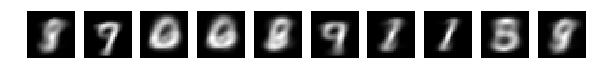

In [13]:
n_examples = 10

fig, axs = plt.subplots(1,n_examples, figsize=(n_examples, 1))

z_gen = np.random.normal(0, 1, [n_examples, n_latent])
imgs = sess.run(dec, feed_dict = {z: z_gen, keep_prob: 1.0})
img_test = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]
for example_i in range(n_examples):
    # original
    axs[example_i].imshow(img_test[example_i], cmap='gray')
    axs[example_i].axis('off')

fig.show()
plt.draw()